In [1]:
# https://charlieoneill.medium.com/predicting-the-price-of-bitcoin-with-multivariate-pytorch-lstms-695bc294130

import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
class StockForecast:
    
    def __init__(self):
        self.epochs = 1000
        self.learning_rate = 0.001 # 0.001 lr

        self.input_size = 4 # number of features
        self.hidden_size = 2 # number of features in hidden state
        self.num_layers = 1 # number of stacked lstm layers
        self.num_classes = 50 # number of output classes 
        
        self.num_sequences = 100
        self.num_predictions = 50
        
        self.raw_data = None
        self.mm = MinMaxScaler()
        self.ss = StandardScaler()

    def load_data(self, fn: str):
        self.raw_data = pd.read_csv('spydata.csv', index_col = 'Date', parse_dates=True)
        self.raw_data(columns=['Adj Close'], inplace=True)
        
    def normalize_data(self):
        # X contains all columns except `Close`
        # Y contains only `Close`
        X, y = df.drop(columns=['Close']), df.Close.values.reshape(-1, 1)    

        X_trans = ss.fit_transform(X)
        y_trans = mm.fit_transform(y)
        
        n_in = 100
        n_out = 50

        X_ss, y_mm = split_sequences(X_trans, y_trans, n_in, n_out)
        print(X_ss.shape, y_mm.shape)
        

In [204]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

In [104]:
df = pd.read_csv('spydata.csv', index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2015-06-22,211.910004,212.589996,211.639999,211.889999,70696000
2015-06-23,212.139999,212.440002,211.570007,212.039993,68476800
2015-06-24,211.720001,212.169998,210.470001,210.500000,92307300
2015-06-25,211.100006,211.250000,209.770004,209.860001,97107400
2015-06-26,210.289993,210.580002,209.160004,209.820007,104174800


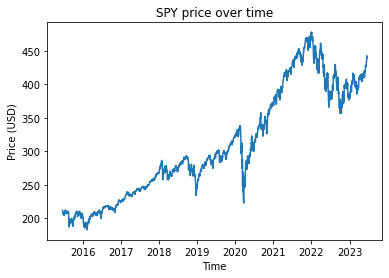

In [105]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("SPY price over time")

plt.savefig("initial_plot.png", dpi=300)
plt.show();

In [110]:
X, y = df.drop(columns=['Close']), df.Close.values.reshape(-1, 1)
X.shape, y.shape

((2012, 4), (2012, 1))

In [113]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y)

In [114]:
n_in = 100
n_out = 50

X_ss, y_mm = split_sequences(X_trans, y_trans, n_in, n_out)
print(X_ss.shape, y_mm.shape)

(1864, 100, 4) (1864, 50)


In [115]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)
test_samples = total_samples - train_test_cutoff

X_train = X_ss[:-test_samples]
X_test = X_ss[-test_samples:]

y_train = y_mm[:-test_samples]
y_test = y_mm[-test_samples:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (1663, 100, 4) (1663, 50)
Testing Shape: (201, 100, 4) (201, 50)


In [116]:
import torch
import torch.nn as nn
from torch.autograd import Variable

# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [117]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True ) # , dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [128]:
n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [129]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [130]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [131]:
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2])) 

# X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
# X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([1663, 100, 4]) torch.Size([1663, 50])
Testing Shape: torch.Size([201, 100, 4]) torch.Size([201, 50])


In [132]:
training_loop(
    n_epochs=n_epochs,
    lstm=lstm,
    optimiser=optimiser,
    loss_fn=loss_fn,
    X_train=X_train_tensors_final,
    y_train=y_train_tensors,
    X_test=X_test_tensors_final,
    y_test=y_test_tensors
)

Epoch: 0, train loss: 0.29068, test loss: 0.54537
Epoch: 100, train loss: 0.02298, test loss: 0.01148
Epoch: 200, train loss: 0.00482, test loss: 0.01155
Epoch: 300, train loss: 0.00312, test loss: 0.00718
Epoch: 400, train loss: 0.00279, test loss: 0.00593
Epoch: 500, train loss: 0.00261, test loss: 0.00544
Epoch: 600, train loss: 0.00252, test loss: 0.00525
Epoch: 700, train loss: 0.00249, test loss: 0.00510
Epoch: 800, train loss: 0.00247, test loss: 0.00500
Epoch: 900, train loss: 0.00245, test loss: 0.00493
Epoch: 1000, train loss: 0.00244, test loss: 0.00487
Epoch: 1100, train loss: 0.00243, test loss: 0.00483
Epoch: 1200, train loss: 0.00242, test loss: 0.00480
Epoch: 1300, train loss: 0.00241, test loss: 0.00479
Epoch: 1400, train loss: 0.00240, test loss: 0.00477


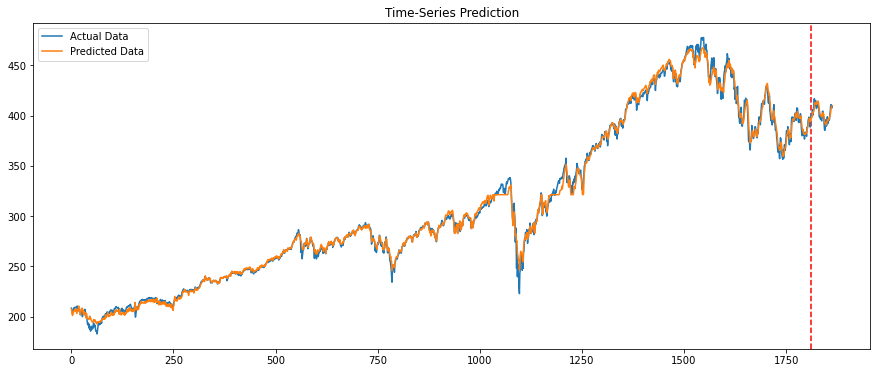

In [158]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers

# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)

# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))

# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

true = dataY_plot[:,0]
preds = data_predict[:,0]

plt.figure(figsize=(15,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 

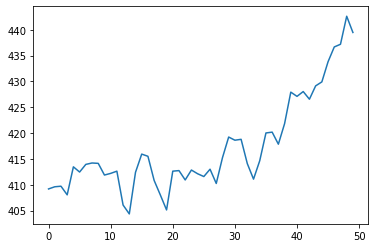

In [167]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
# plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.show();

In [177]:
y_test_tensors[0,]

tensor([0.6519, 0.6496, 0.6620, 0.7028, 0.6977, 0.6708, 0.6698, 0.6593, 0.6728,
        0.6753, 0.6796, 0.6991, 0.6980, 0.6830, 0.6714, 0.6646, 0.6615, 0.6860,
        0.6752, 0.7102, 0.7187, 0.7323, 0.7198, 0.7214, 0.7055, 0.7400, 0.7570,
        0.7771, 0.7730, 0.7638, 0.7855, 0.7845, 0.7821, 0.7805, 0.7749, 0.8042,
        0.8042, 0.8284, 0.8343, 0.8372, 0.8268, 0.8310, 0.8115, 0.7817, 0.7783,
        0.7828, 0.8026, 0.7545, 0.7454, 0.7304])

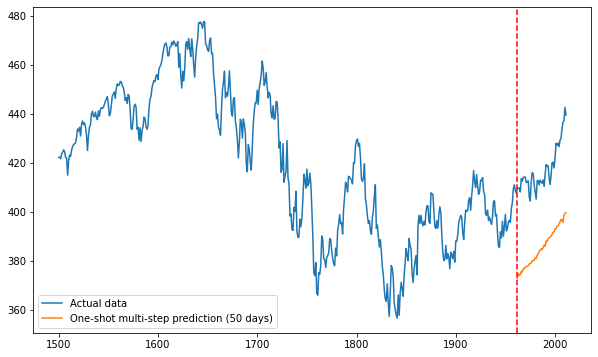

In [160]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(1500, len(y))]
plt.plot(a, y[1500:], label='Actual data');
c = [x for x in range(len(y)-50, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (50 days)')
plt.axvline(x=len(y)-50, c='r', linestyle='--')
plt.legend()
plt.show()

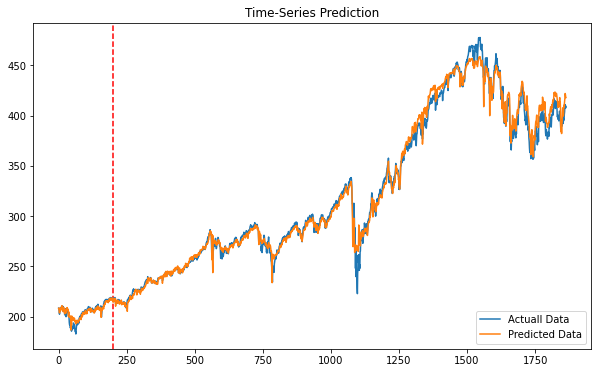

In [101]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers

# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)

# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))

# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot[:,0], label='Actuall Data') #actual plot
plt.plot(data_predict[:,0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 